<a href="https://colab.research.google.com/github/Rushi873/Option-pricing-models/blob/main/LSTM_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import pandas_datareader as web
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [2]:
# Loading Data,
company = 'GS'     # change ticker symbol to get the prediction

start = dt.datetime(2010, 1, 1)
end = dt.datetime(2021, 1, 1)

data = web.DataReader(company, 'stooq', start, end)
data

,Open,High,Low,Close,Volume
Date,,,,,
2020-12-31,247.803,252.713,247.019,252.497,2.133763e+06
2020-12-30,247.813,249.576,246.872,248.410,1.636333e+06
2020-12-29,249.194,249.783,245.598,247.029,1.494400e+06
2020-12-28,246.852,251.498,246.078,248.547,2.917421e+06
2020-12-24,246.117,246.665,242.962,245.265,1.011133e+06
...,...,...,...,...,...
2010-01-08,144.811,145.761,142.909,143.184,8.834766e+06
2010-01-07,143.194,146.869,142.909,145.957,1.060932e+07
2010-01-06,144.095,144.095,142.733,143.154,8.972135e+06


In [3]:

# Preparing data
scalar = MinMaxScaler(feature_range=(0,1))      # using feature scaling
scaled_data = scalar.fit_transform(data['Close'].values.reshape(-1,1))

predication_days = 20

x_train = []
y_train = []

for x in range(predication_days, len(scaled_data)):
  x_train.append(scaled_data[x - predication_days:x , 0]) # from day 0 to day x, and creating 2D array
  y_train.append(scaled_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1) )


In [4]:
#Building Machine learning model
model = Sequential()

model.add(LSTM(units = 42, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.15))
model.add(LSTM(units = 42, return_sequences = True))
model.add(Dropout(0.15))
model.add(LSTM(units = 42))
model.add(Dropout(0.15))
model.add(Dense(units=1))

model.compile(optimizer ='adam', loss = 'mean_squared_error')
model.fit(x_train, y_train, epochs = 19, batch_size = 34)

Epoch 1/19
81/81 [==============================] - 18s 29ms/step - loss: 0.0262
Epoch 2/19
81/81 [==============================] - 2s 29ms/step - loss: 0.0042
Epoch 3/19
81/81 [==============================] - 3s 32ms/step - loss: 0.0040
Epoch 4/19
81/81 [==============================] - 3s 40ms/step - loss: 0.0036
Epoch 5/19
81/81 [==============================] - 2s 29ms/step - loss: 0.0033
Epoch 6/19
81/81 [==============================] - 2s 29ms/step - loss: 0.0034
Epoch 7/19
81/81 [==============================] - 2s 29ms/step - loss: 0.0029
Epoch 8/19
81/81 [==============================] - 3s 31ms/step - loss: 0.0030
Epoch 9/19
81/81 [==============================] - 3s 40ms/step - loss: 0.0027
Epoch 10/19
81/81 [==============================] - 2s 29ms/step - loss: 0.0027
Epoch 11/19
81/81 [==============================] - 2s 29ms/step - loss: 0.0026
Epoch 12/19
81/81 [==============================] - 2s 29ms/step - loss: 0.0023
Epoch 13/19
81/81 [=================

In [5]:
# Backtesting
test_start = dt.datetime(2021, 1, 2)
test_end = dt.datetime.now()

test_data = web.DataReader(company, 'stooq', test_start, test_end)
actual_price = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']))

model_inputs = total_dataset[len(total_dataset) - len(test_data) - predication_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scalar.transform(model_inputs)

In [6]:
# Making prediction on test data
x_test = []

for x in range(predication_days, len(model_inputs)):
  x_test.append(model_inputs[x - predication_days : x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicated_prices = model.predict(x_test)
predicated_prices = scalar.inverse_transform(predicated_prices)

26/26 [==============================] - 2s 9ms/step


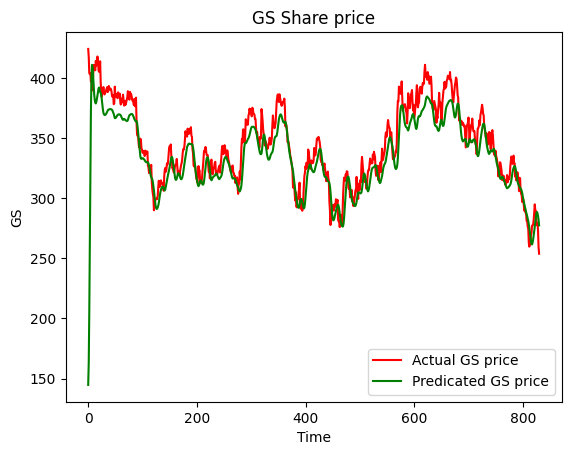

In [7]:
#plot the test predication
plt.plot(actual_price, color = 'red', label = f"Actual {company} price")
plt.plot(predicated_prices, color = 'green', label = f"Predicated {company} price")
plt.title(f"{company} Share price")
plt.xlabel('Time')
plt.ylabel(f"{company}")
plt.legend()
plt.show()

In [8]:
#predict next day
real_data = [model_inputs[len(model_inputs) + 1 - predication_days: len(model_inputs+1), 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

predication = model.predict(real_data)
predication = scalar.inverse_transform(predication)
print(f"Predication: {predication}")

1/1 [==============================] - 1s 1s/step
Predication: [[270.1987]]


In [9]:
data = web.DataReader(company, 'stooq', dt.datetime(2021, 1, 1), dt.datetime(2021, 1, 4))
real = int(data.Close)
accuracy = 100 - abs(((real - predication )/real)*100)
print(f"accuracy of predication is {accuracy}%")

accuracy of predication is [[93.202095]]%


<ipython-input-9-b79b9cebc15b>:2: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  real = int(data.Close)
